# 2) Custom Inference
The previous notebook, `1-simple-inference.ipynb` showed how to quickly run inference with the `pitchfork_sampler` default setup.

In reality, we can tune parts of the sampling pipeline described in the paper, which I'll split into three parts:
1. Priors
2. `UltraNest` parameters
3. Surface term GP parameters

By default, `pitchfork_sampler` will use:
1. The priors used in the paper, which are bounded to the trained ranges of `pitchfork`
2. The `UltraNest` defaults (with the exception of `ndraw_min` and `ndraw_max`, which we'll get to later)
3. The GP variance and lengthscale factor used in the paper for sampling Solar fundamental properties (`gp_var = 4` and `gp_ls_factor=7`, respectively).

In many cases, these defaults should work well (and are safe!). Regardless, here I'll show you how to customise some of these properties if, for instance, you want to restrict your priors for a given star, or turn down `ndraw_max` so the sampler doesn't OOM your laptop.

At the end, I'll show how to tweak the sampler to work for your own stars instead of using the defaults (which are chosen to work well on Solar data), by going through examples with 16 Cyg A and B.

We'll start with **1. Priors**.

In [1]:
import numpy as np
import json
import corner
import matplotlib.pyplot as plt

from scripts import pitchfork_compile, pitchfork_sampler, posterior_plot

### compile pitchfork

with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

pitchfork = pitchfork_compile(pitchfork_dict, pitchfork_info)

## 1. Priors
Before, we initialised the sampler without specifying our prior beforehand which means we fall back to the default priors use in the paper:

In [ ]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

priors = sampler.priors

labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

size = 10000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])

corner.corner(prior_samples.T, color='black', labels = labels, hist_kwargs={'density':True}, smooth=True);
plt.suptitle('prior samples')
plt.show()

I leave these as defaults partly because they'll work fine in many cases, but much more importantly:

**!!! NEURAL NETWORKS DO SILLY THINGS OUTSIDE THE BOUNDS OF THEIR TRAINING DATA - YOU HAVE BEEN WARNED !!!**

Read the paper to find out more, but in short - these priors were chosen specifically to stop `pitchfork` from being asked to predict for inputs that fall outside of the trained range of the grid.

Outside of this trained range, interpolation becomes extrapolation. `pitchfork` will start making wacky predictions (I'm talking $L_\text{pred}=1\times10^{64}\,L_{\odot}$, $T_\text{pred}=1\times10^{-6}\,\text{K}$ levels of wacky) that are in no way represented by the summary statistic for `pitchfork` precision that we use to define the likelihood function.

That being said, it's fine to *restrict* the prior ranges to within the trained range of `pitchfork` if you need to, or change the functional form of the priors. Also, given that `pitchfork` is only trained on the fundamental properties (`initial_mass`, `initial_Zinit`, `initial_Yinit`, `initial_MLT`, `star_age`) you're free to change the ranges on the surface term parameters `a` and `b` as much as you like.

I've included some helper functions in `utils.py` for making beta and uniform priors like we do in the paper - I recommend sticking to these because you can specify hard limits for the prior to avoid `pitchfork` extrapolation, but feel free to restrict the range or mess with the shape parameters:

In [ ]:
from scripts import beta_prior, uniform_prior
# beta_prior(min, max, a, b)
# uniform_prior(min, max)

mass_prior = uniform_prior(0.95, 1.05) #<- default: beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = uniform_prior(0.008, 0.02) #<- default: beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = uniform_prior(0.25, 0.28) #<- default: beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = uniform_prior(2.1, 2.2) #<- default: beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = uniform_prior(2, 6) #<- default: beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = uniform_prior(-4, 0) #<- default: uniform_prior(-10, 2)

b_prior = uniform_prior(3.8, 5.5) #<- default: uniform_prior(4.4, 5.25)

custom_priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

Having defined our custom priors, we just pass them to the `pitchfork_sampler` object along with `pitchfork` when initialising and then we can sample and plot as before:

In [ ]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov, priors=custom_priors)

priors = sampler.priors

labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

size = 10000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])

corner.corner(prior_samples.T, color='black', labels = labels, hist_kwargs={'density':True}, smooth=True);
plt.suptitle('prior samples')
plt.show()

Funky! But fine for `pitchfork` :)

Let's see how a nested sampling run using these priors looks for the sun:

In [ ]:
star_name = 'Sun'

results = sampler(star_name)

posterior_plot(results, include_prior=True, star_name=star_name);

## 2. UltraNest parameters
There are several parameters that we can tune within `UltraNest` that can change how our sampler behaves. I won't go into too much detail on what these actually do here - you can find that in the [docs](https://johannesbuchner.github.io/UltraNest/index.html).

`pitchfork_sampler` will just use the `UltraNest` defaults for most of these, which will work well in many cases (but I'll show you how to tweak some of these later).

The only ones that aren't the `UltraNest` defaults are `ndraw_min` and `ndraw_max`.

### 2.1. `ndraw_min` and `ndraw_max`
These parameters control the number of points that are proposed simultaneously by the sampler to be evaluated via the likelihood function.

`UltraNest` starts by drawing at `ndraw_max`, and then will dynamically reduce the number of draws if the efficiency (see `eff` value in `UltraNest` readout) drops, to a lower limit of `ndraw_min`.

The defaults are `ndraw_min=128` and `ndraw_max=65536`. The [docs](https://johannesbuchner.github.io/UltraNest/index.html) says for both of these parameters to "*Increase this if your likelihood makes vectorization very cheap*".

**Our `pitchfork` likelihood makes vectorisation *very* cheap.**

Therefore, I set the defaults to `ndraw_min=1024` and `ndraw_max=524288`.

Even though `Ultranest` will rapidly drop from `ndraw_max` in a few iterations, it may be that these defaults are too intense for your machine. In that case, we can easily reduce like so:

In [ ]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun',ndraw_min=512, ndraw_max=262144)

This should still be reasonably fast, and may even be faster than the defaults if your machine was struggling with memory bottlenecks before.

I'd avoid setting both `ndraw_min` and `ndraw_max` to high values, because the final stages of nested sampling take many many iterations in a small area of parameter space, within which making many draws is completely unneccassary (which is why `UltraNest` dynamically reduces the number of draws). It's best to have a wide range, like shown above.

### 2.2. `frac_remain`
Another `UltraNest` parameter which might come in handy is `frac_remain`, which defines the fraction of the integral left in the remainder at which `UltraNest` should stop sampling.

I've left this at the default, `frac_remain=0.01`, which works well in many cases (the [docs](https://johannesbuchner.github.io/UltraNest/index.html) say that a higher number, like 0.5, is fine if we know the posterior is simple - which we'd expect for solar-like oscillators).

However, there are a couple reasons why you might want to change this - for instance, if you're bugfixing and don't necessarily care about the sampler meaningfully constraining the posterior, you might want to set the `frac_remain` very high like so:

In [ ]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun',frac_remain=0.5)

Fast!

Or, if you'd like to make sure you've **really** found those peaks, you could set this very low (which may take quite a bit longer):

In [ ]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

results = sampler('Sun',frac_remain=1e-5)

### 2.3. `min_num_live_points`
One of the most common questions on nested sampler docs FAQs is: "How many live points should I use?". It seems like there isn't really an answer to this beyond: "It completely depends on your problem, machine, and the complexity of the posterior."

Put simply, the live points are the points in parameter space that are actively evaluated as the nested sampler progresses, and control the resolution of the posterior we return. Too few and we risk missing out on peaks in our posterior or ending up with jagged posterior distributions. Too many and our sampler takes an age to run and arrives at the same solutions that we'd have found by using fewer.

The `UltraNest` default is 400, which I've left as the default for `pitchfork_sampler` too - this seems reasonable if we also follow the guidance in the [`dynesty` docs](https://dynesty.readthedocs.io/en/v3.0.0/faq.html#live-point-questions): "*Around 50 * ndim points are recommended for each expected mode.*". We are sampling over 7 dimensions, and don't necessarily expect our posteriors to be multimodal.

That being said, it may be that the particular star you're sampling has a complex posterior, or your laptop struggles with `min_num_live_points=400`. Let's see what happens if we use just 10 live points:

In [13]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

low_live_results = sampler('Sun', min_num_live_points = 10)

[pitchfork_sampler] sampling posterior of Sun...
[ultranest] To achieve the desired logz accuracy, min_num_live_points was increased to 64
[ultranest] Sampling 64 live points from prior ...


[ultranest] Explored until L=-2  91 [-2.4099..-2.3246] | it/evals=1338/30520 eff=4.3932% N=64        4   4      
[ultranest] Likelihood function evaluations: 30748
[ultranest] Will add 16 live points (x1) at L=-3 ...
[ultranest] Explored until L=-2  89 [-2.4006..-2.3033] | it/evals=1380/37170 eff=0.5216% N=80 
[ultranest] Likelihood function evaluations: 37170
[ultranest]   logZ = -18.57 +- 0.4566
[ultranest] Effective samples strategy wants to improve: -12.47..-2.04 (ESS = 377.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 77 minimum live points (dlogz from 0.38 to 0.86, need <0.5)
[ultranest]   logZ error budget: single: 0.42 bs:0.46 tail:0.01 total:0.46 required:<0.50
[ultranest] Widening roots to 77 live points (have 64 already) ...
[ultranest] Sampling 13 live points from prior ...
[ultranest] Exploring (in particular: L=-12.47..-2.04) ...
[ultranest] Explored until L=-2  83

A few interesting things happened there!

- Firstly, that was ridiculously fast!

- Also, `UltraNest` immediately updated to 64 live points instead of the 10 we asked for with the message:
    ```
    [ultranest] To achieve the desired logz accuracy, min_num_live_points was increased to 64
    ```
    
    This happens because `UltraNest` initialises with a target accuracy on the log evidence, `logz`, which is proportional to $1\over{\sqrt{N_{\text{live}}}}$. If $N_{\text{live}}$ is too low, this target cannot be reached, and `UltraNest` automatically increases.

- After sampling with $N_{\text{live}}=64$ for a while. `UltraNest` adds even more live points and prints a line like:
    ```
    [ultranest] Widening roots to 76 live points (have 64 already) ...
    ```
    This happens when `UltraNest` detects that the current number is insufficient for proper exploration of the likelihood surface. This is why the argument is `min_num_live_points` and not `num_live_points` - `UltraNest` automatically increases the number of live points if needed!

- The final thing you might have noticed is that the live plot looked much more patchy than usual - these bars indicate roughly where in parameter space the live points are currently populated, and so it makes sense that using fewer live points means these plots are more jagged than with $N_{\text{live}}=400$! However, the final position of the live points looks like they're evenly clustered around the peaks in the Solar posteriors that we've seen so far, which is a good sign.

So if our sampling is *outrageously* fast when we set `min_num_live_points=10` and just let `UltraNest` decide how many live points to use, and the live points have still converged about the peaks of the posterior that we've seen when using `min_num_live_points=400`, why don't I just use 10 as the default?

Let's check the posteriors we recieved from our most recent run:


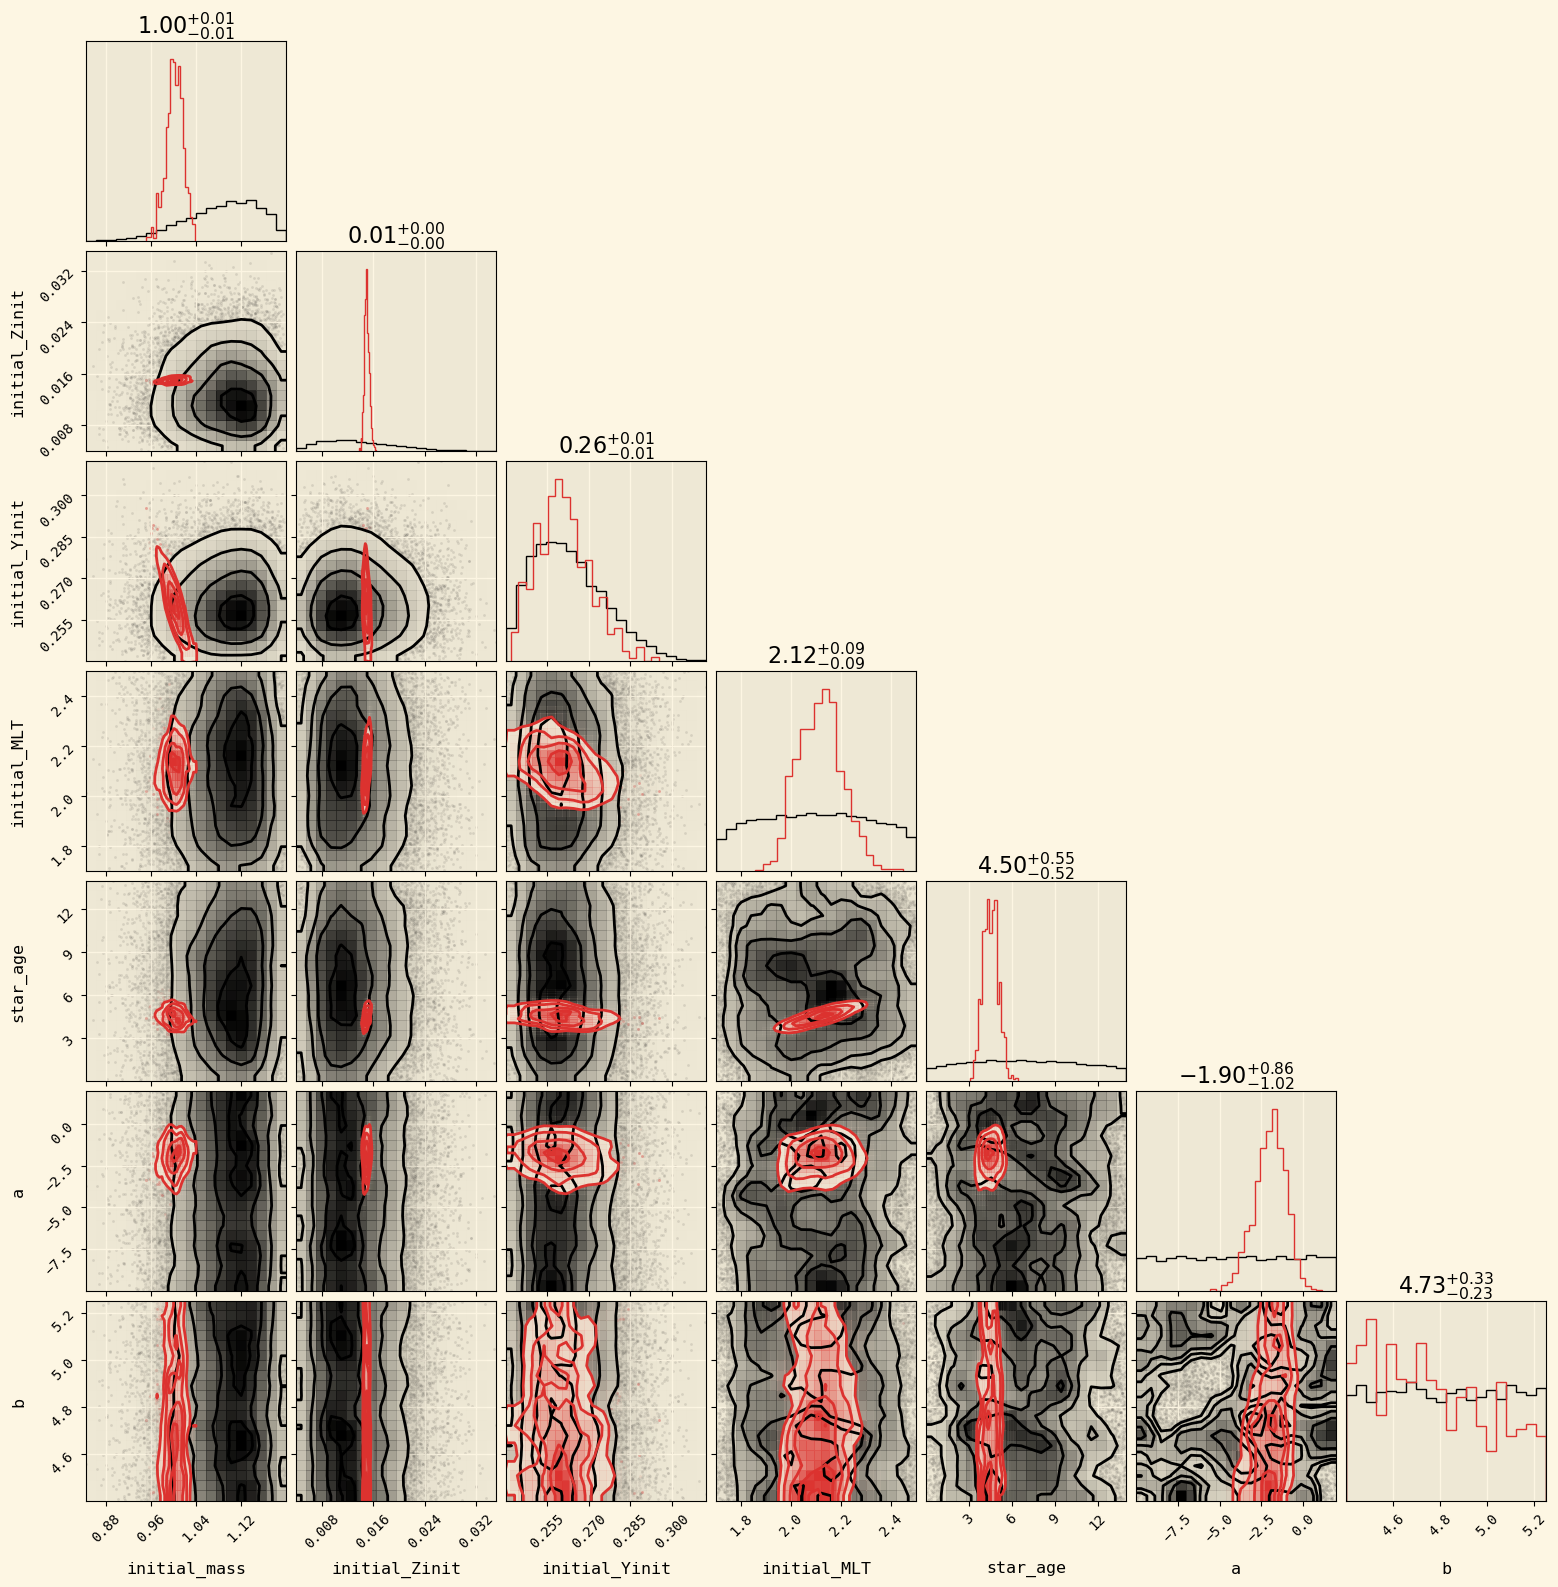

In [4]:
posterior_plot(results, include_prior=True);

Despite having converged about values that agree with our previous posteriors, these posterior distributions are certainly not smooth with well defined peaks. In fact, they contain *far* fewer samples than our results when using `min_num_live_points=400`:

In [10]:
print(f'samples in posterior with min_num_live_points=10: {len(low_live_results['samples'])}')

print(f'samples in posterior with min_num_live_points=400: {len(results['samples'])}')

samples in posterior with min_num_live_points=10: 1530
samples in posterior with min_num_live_points=400: 8613


This is why it's probably best to stick with at least a few hundred live points - the extra minute it takes to sample is worth it for the smooth and well sampled posteriors we end up with :)

That being said, it might be worth reducing from the default 400 if you're struggling with compute time or are just quickly checking that the sampler is capable of converging at all with your data.

## 3. Surface term GP parameters
Another feature of our sampler is a Gaussian Process (GP) correlated noise model.

Please check the paper for a description on how/why we do this, and the `pitchfork_sampler` source code to see how I implement it, but there are two important parameters of the GP that determine the maximum flexibility (the **Variance**) and how quickly the functions can vary over the parameter space (the **lengthscale**).

For our correlated noise model, the variance variable, `gp_var`, has units of $\mu\text{Hz}^{2}$, and the lengthscale, `gp_ls_factor` is defined as a factor of the large frequency separation $\Delta\nu$.

The optimal choice for these is frequency-dependent, and thus varies on a star-by-star basis. Given we are interested in solar-like oscillators here, I set the default values to be those that we found optimal for the Sun in the sparse GP parameter gridsearch we carried out in the paper: `gp_var=4` and `gp_ls_factor=7` - these should work reasonably well for most stars in the parameter range we consider.

However, if you'd like to change these, they can be passed as arguments to your sampler. I'll show an example here that varies `gp_var` and `gp_ls_factor` and compares the returned evidences (which are also stored in the dict returned by calling the sampler) to find which combination best describes the data (this may take a couple minutes):

In [2]:
#sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

gp_vars = [4, 10]
gp_ls_factors = [2, 7]

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Initiating GP parameter gridsearch:  ')
print('')
results_dict = {}
for gp_var in gp_vars:
    for gp_ls_factor in gp_ls_factors:
        print(f'Sampling for gp_var={gp_var} and gp_ls_factor={gp_ls_factor}...')
        print('')
        sampler = pitchfork_sampler(pitchfork, pitchfork_cov)
        results = sampler('Sun',
                          gp_var=gp_var,
                          gp_ls_factor=gp_ls_factor,
                          frac_remain = 0.5, #<- earlier stopping criterion, see above
                          viz_callback=False #<- this just turns off the live plots
                         )
        results_dict[f'var{gp_var}_ls{gp_ls_factor}'] = [results['logz'], results['logzerr']]
        del results
        print('')

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Done! Printing results of gridsearch:')
print('')
for gp_var in gp_vars:
    for gp_ls_factor in gp_ls_factors:
        logz, logzerr = results_dict[f'var{gp_var}_ls{gp_ls_factor}']
        print(f'Evidence and error for gp_var={gp_var} and gp_ls_factor={gp_ls_factor}: {logz}, {logzerr}')
        print('')
        

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initiating GP parameter gridsearch:  

Sampling for gp_var=4 and gp_ls_factor=2...

[pitchfork_sampler] sampling posterior of Sun...
[pitchfork_sampler] GP params: gp_var=4, gp_ls_factor=2.
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+01   [-15.0438..-15.0427]*| it/evals=5753/230068 eff=1.0040% N=400    0   0  0   
[ultranest] Likelihood function evaluations: 230068
[ultranest]   logZ = -27.97 +- 0.1442
[ultranest] Effective samples strategy satisfied (ESS = 920.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.43, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.41 total:0.43 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 3m 11.7s!

Sampling for gp_var=4 and gp_ls_factor=7...

[pitchfork_sampler] sampling posterior of Sun...
[pitchfork_sam

## 16 Cyg A & B 
Let's see how we can use the customisations above to run `pitchfork_sampler` on a stars that aren't the sun!

The `/stars/...` folder should already contain data for 16 Cyg A - let's take a look:

In [12]:
star_name = '16CygA'

with open(f'stars/{star_name}/{star_name}.json', 'r') as fp:
    star_dict = json.load(fp)

star_dict

{'calc_effective_T': [5839, 42],
 'luminosity': [1.56, 0.05],
 'star_feh': [0.096, 0.026],
 'nu_0_12': [1390.80819, 0.75733],
 'nu_0_13': [1495.05303, 0.24309],
 'nu_0_14': [1598.68962, 0.07498],
 'nu_0_15': [1700.95243, 0.10148],
 'nu_0_16': [1802.35128, 0.08378],
 'nu_0_17': [1904.52077, 0.05845],
 'nu_0_18': [2007.53798, 0.04187],
 'nu_0_19': [2110.94955, 0.03737],
 'nu_0_20': [2214.22506, 0.05468],
 'nu_0_21': [2317.28211, 0.05534],
 'nu_0_22': [2420.9372, 0.08204],
 'nu_0_23': [2524.94962, 0.14781],
 'nu_0_24': [2628.92966, 0.25724],
 'nu_0_25': [2733.57075, 0.44461],
 'nu_0_26': [2840.1478, 1.05838],
 'nu_0_27': [2944.93722, 0.89642],
 'dnu': [103.3, 0],
 'nu_max': [2188.0, 0]}

Certainly not Solar!

We'll use the GP parameters that we found to be optimal for 16 Cyg A in the paper:

In [13]:
sampler = pitchfork_sampler(pitchfork, pitchfork_cov)

A_results = sampler('16CygA', gp_var = 4, gp_ls_factor = 6, frac_remain=0.2)

[pitchfork_sampler] sampling posterior of 16CygA!
[pitchfork_sampler] GP params: gp_var=4, gp_ls_factor=6
[pitchfork_sampler] Considering freqs in range: 12 ≤ n ≤ 27
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+01   [-11.4345..-11.4332]*| it/evals=5851/371347 eff=0.6240% N=400 0  0  0 0 0 
[ultranest] Likelihood function evaluations: 371347
[ultranest]   logZ = -24.16 +- 0.09958
[ultranest] Effective samples strategy satisfied (ESS = 1847.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.10 tail:0.18 total:0.21 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 2m 18.6s!


And now let's check the results:

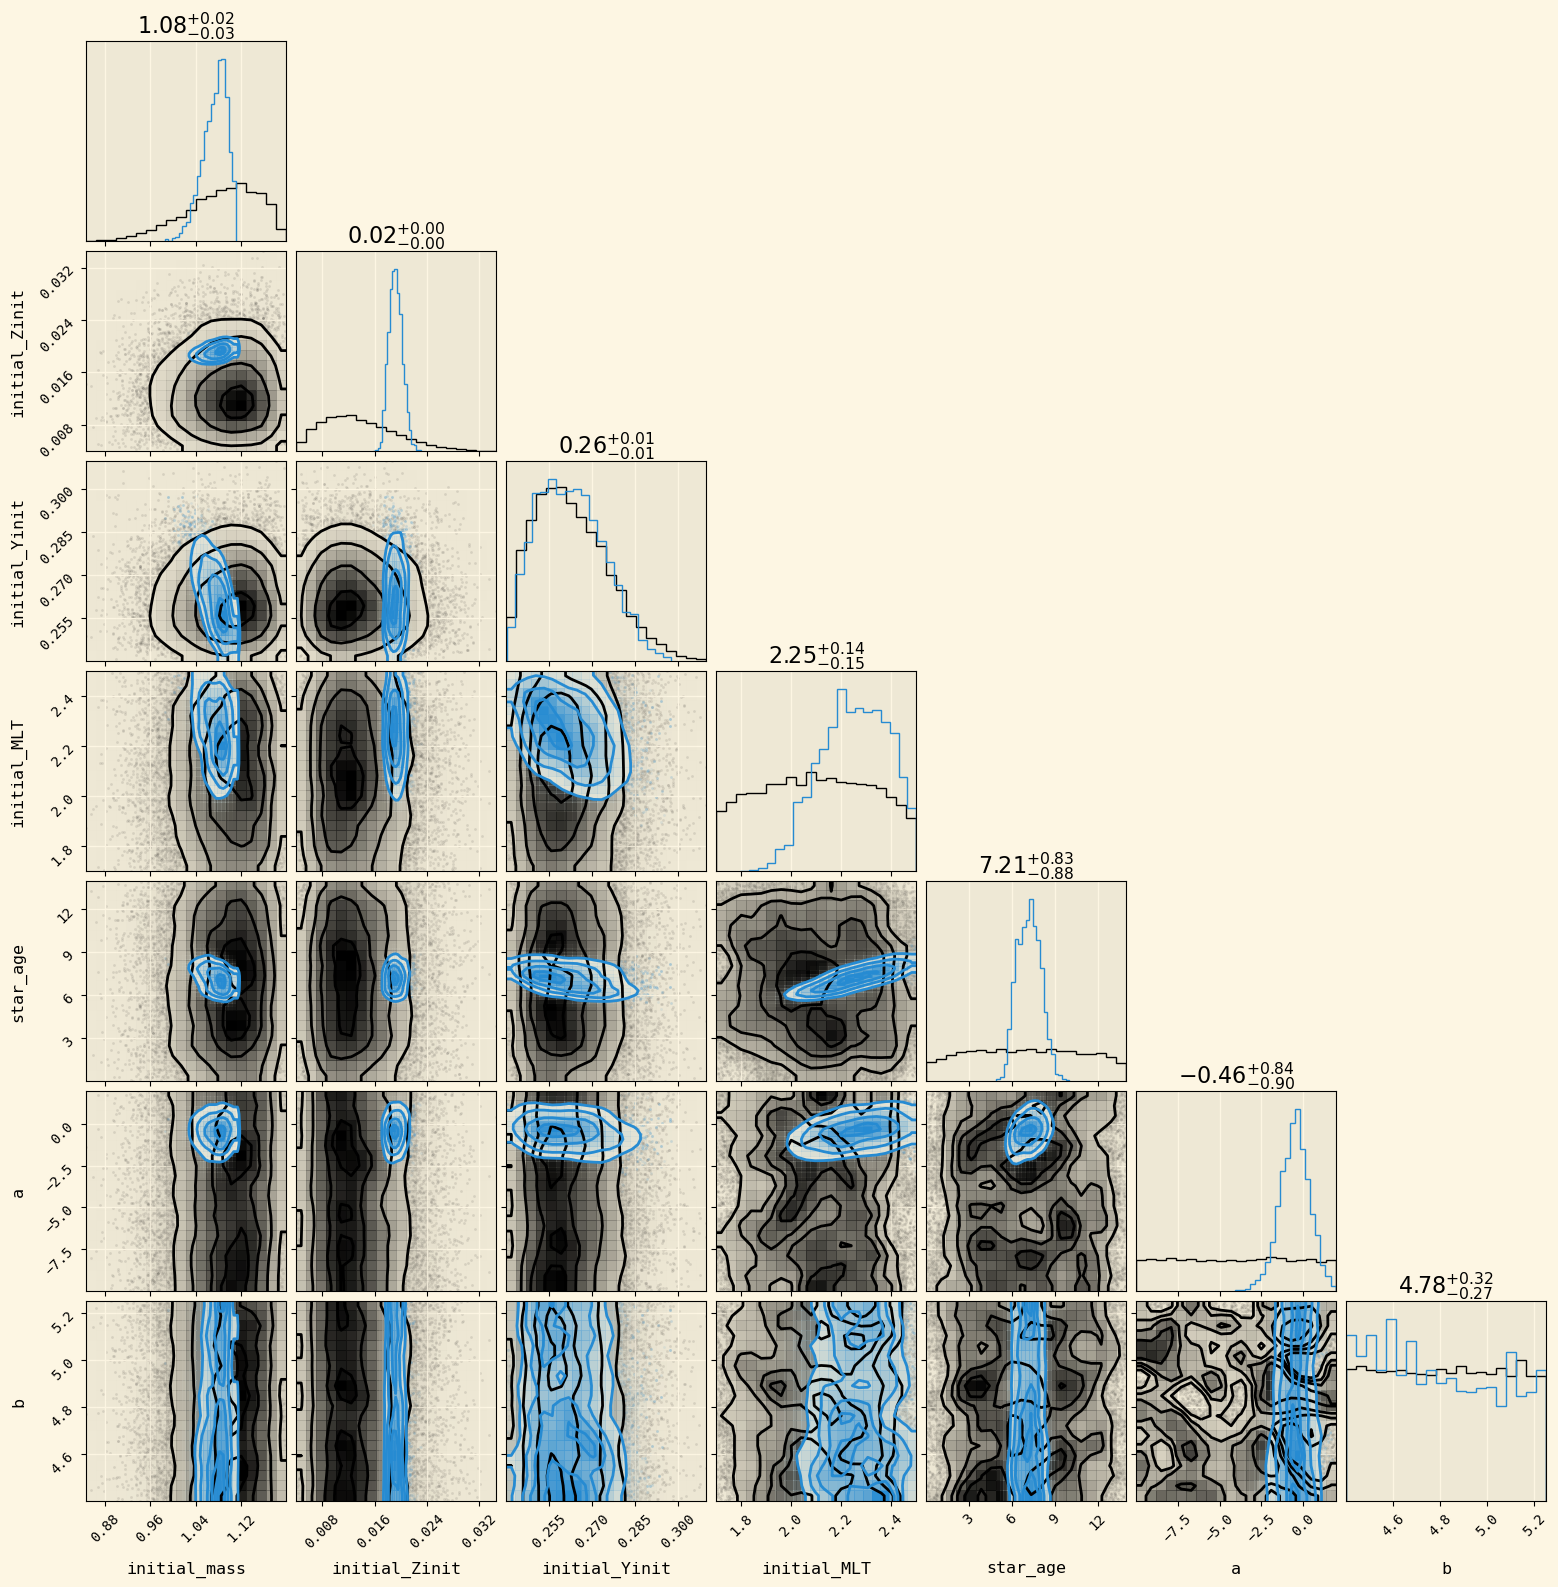

In [14]:
posterior_plot(A_results, color='#268BD2', include_prior=True);

Nice! Now let's try the same for B so we can check whether we get the expected agreement between `initial_Zinit` and `star_age`...

In [15]:
star_name = '16CygB'

with open(f'stars/{star_name}/{star_name}.json', 'r') as fp:
    star_dict = json.load(fp)

star_dict

{'calc_effective_T': [5809, 39],
 'luminosity': [1.27, 0.04],
 'star_feh': [0.052, 0.021],
 'nu_0_13': [1695.02292, 0.14096],
 'nu_0_14': [1812.44447, 0.1465],
 'nu_0_15': [1928.88625, 0.11],
 'nu_0_16': [2044.35684, 0.07089],
 'nu_0_17': [2159.50294, 0.0568],
 'nu_0_18': [2275.94878, 0.04924],
 'nu_0_19': [2392.64451, 0.0455],
 'nu_0_20': [2509.67826, 0.04333],
 'nu_0_21': [2626.45779, 0.05174],
 'nu_0_22': [2743.32186, 0.06584],
 'nu_0_23': [2860.68003, 0.09407],
 'nu_0_24': [2978.17998, 0.17118],
 'nu_0_25': [3097.16961, 0.41425],
 'nu_0_26': [3216.45122, 0.45259],
 'nu_0_27': [3336.00875, 1.03806],
 'dnu': [116.9, 0],
 'nu_max': [2561.0, 0]}

In [16]:
B_results = sampler('16CygB', gp_var = 4, gp_ls_factor = 5, frac_remain=0.2)

[pitchfork_sampler] sampling posterior of 16CygB!
[pitchfork_sampler] GP params: gp_var=4, gp_ls_factor=5
[pitchfork_sampler] Considering freqs in range: 13 ≤ n ≤ 27
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9  76 [-9.9165..-9.9147]*| it/evals=5843/244871 eff=2.0588% N=400        0  0 0 0 
[ultranest] Likelihood function evaluations: 244886
[ultranest]   logZ = -22.54 +- 0.1252
[ultranest] Effective samples strategy satisfied (ESS = 2012.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.22, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.18 total:0.22 required:<0.50
[ultranest] done iterating.
[pitchfork_sampler] finished in 2m 40.8s!


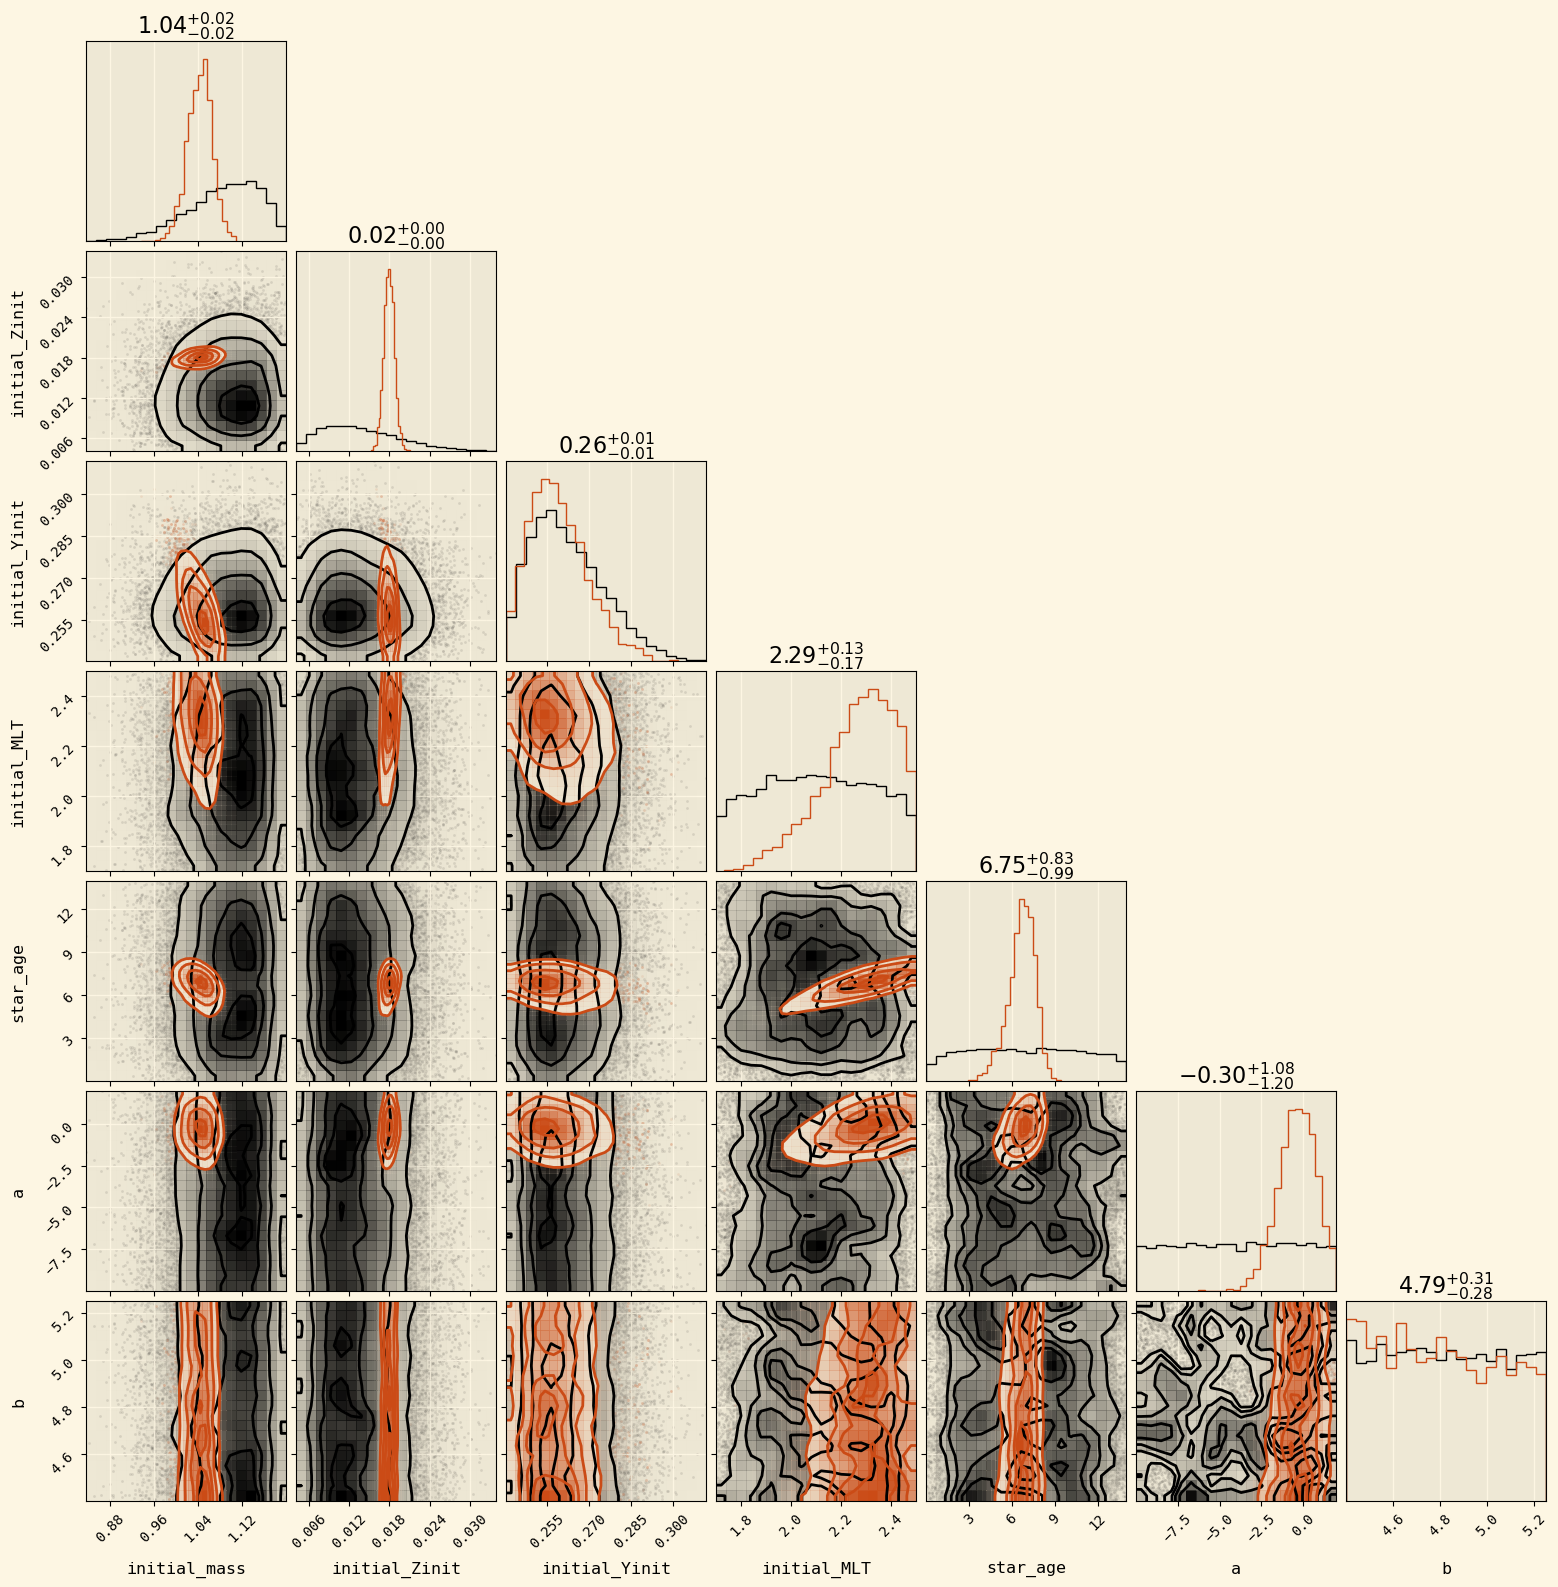

In [17]:
posterior_plot(B_results, color='#CB4B16', include_prior=True);

The moment of truth! Let's plot these posteriors over one another to see whether we get agreement in the binary parameters:

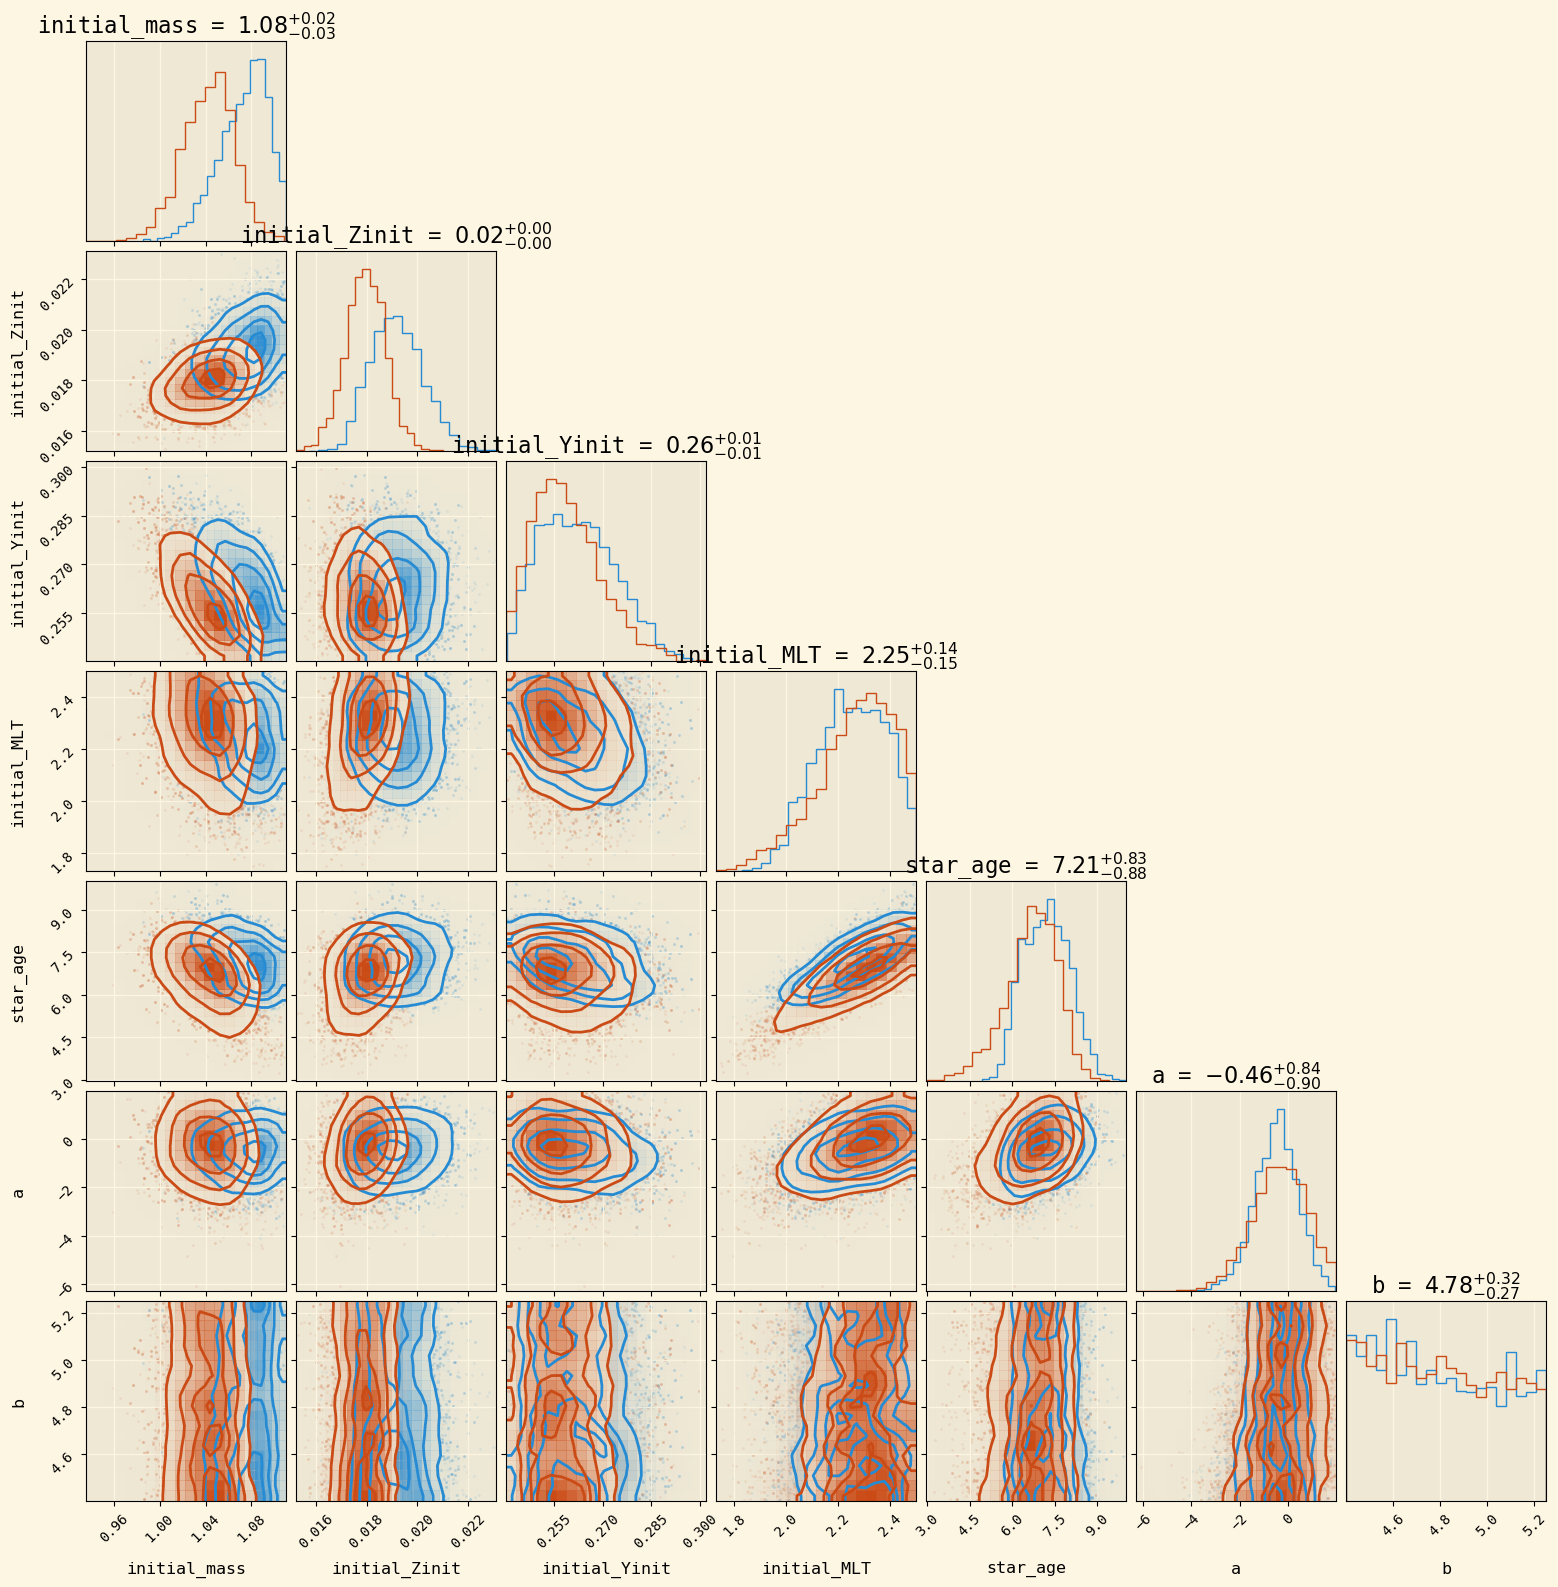

In [19]:
fig = posterior_plot(A_results, color='#268BD2', include_prior=False);

corner.corner(B_results['samples'], fig=fig, color = '#CB4B16', smooth=True, hist_kwargs={'density':True}, show_titles=False);